Reference
---
1. [Detecting Parkinson’s Disease with OpenCV, Computer Vision, and the Spiral/Wave Test](https://www.pyimagesearch.com/2019/04/29/detecting-parkinsons-disease-with-opencv-computer-vision-and-the-spiral-wave-test/)
- [Distinguishing Different Stages of Parkinson’s Disease Using Composite Index of Speed and Pen-Pressure of Sketching a Spiral, by Zham et al.](https://www.frontiersin.org/articles/10.3389/fneur.2017.00435/full), The researchers found that the drawing speed was slower and the pen pressure lower among Parkinson’s patients.
- [Images Dataset, NIATS of Federal University of Uberlândia.](http://www.niats.feelt.ufu.br/en/node/81)
- [Histogram of Oriented Gradients for Human Detection](https://ieeexplore.ieee.org/document/1467360), HOG is a structural descriptor that will capture and quantify changes in local gradient in the input image. HOG will naturally be able to quantify how the directions of a both spirals and waves change. And furthermore, HOG will be able to capture if these drawings have more of a “shake” to them, as we might expect from a Parkinson’s patient.


Parkinson’s disease is a nervous system disorder that affects movement. The disease is progressive and is marked by five different stages (source).

- Stage 1: Mild symptoms that do not typically interfere with daily life, including tremors and movement issues on only one side of the body.
- Stage 2: Symptoms continue to become worse with both tremors and rigidity now affecting both sides of the body. Daily tasks become challenging.
- Stage 3: Loss of balance and movements with falls becoming frequent and common. The patient is still capable of (typically) living independently.
- Stage 4: Symptoms become severe and constraining. The patient is unable to live alone and requires help to perform daily activities.
- Stage 5: Likely impossible to walk or stand. The patient is most likely wheelchair bound and may even experience hallucinations.

While Parkinson’s cannot be cured, early detection along with proper medication can significantly improve symptoms and quality of life, making it an important topic as computer vision and machine learning practitioners to explore.



Introtroduction
---
A 2017 study by [Zham et al.](https://www.frontiersin.org/articles/10.3389/fneur.2017.00435/full) found that it was possible to detect Parkinson’s by asking the patient to draw a spiral and then track:

1. Speed of drawing
- Pen pressure

The researchers found that the drawing speed was slower and the pen pressure lower among Parkinson’s patients — this was especially pronounced for patients with a more acute/advanced forms of the disease.

**Dataset** 
is availed by  [Adriano de Oliveira Andrade and Joao Paulo Folado from the NIATS of Federal University of Uberlândia](http://www.niats.feelt.ufu.br/en/node/81), which consists of 204 images and is pre-split into a training set and a testing set, consisting of:

1. Spiral: 102 images, 72 training, and 30 testing
- Wave: 102 images, 72 training, and 30 testing


In [1]:
!pip install -U scikit-learn #加-U才會安裝到最新版本

Requirement already up-to-date: scikit-learn in /anaconda3/lib/python3.7/site-packages (0.21.1)


In [2]:
!pip install SciPy

In [3]:
!pip install imutils

In [4]:
# import the necessary packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature,exposure
from imutils import build_montages #蒙太奇（把影像做變形）
from imutils import paths
import numpy as np
from tqdm import tqdm,tqdm_notebook

import cv2 #用來轉換image成information
import os

In [5]:
import sklearn.metrics as skm

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

[HOG](https://ieeexplore.ieee.org/document/1467360) is a structural descriptor that will capture and quantify changes in local gradient in the input image. HOG will naturally be able to quantify how the directions of a both spirals and waves change.

In [7]:
feature.hog?

In [7]:
def quantify_image(image):
     # compute the histogram of oriented gradients feature vector for
     # the input image
     features = feature.hog(image, orientations=9,
          pixels_per_cell=(10, 10), cells_per_block=(2, 2),
          transform_sqrt=True, block_norm="L1")

     # return the feature vector
     return features

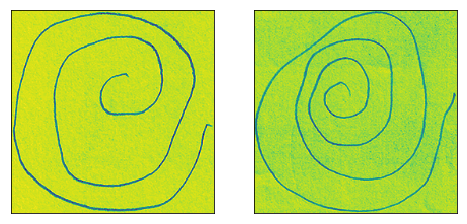

In [8]:
fig = plt.figure(figsize=(8, 8))
img1="dataset/spiral/testing/healthy/V01HE01.png"
img2="dataset/spiral/testing/parkinson/V01PE01.png"
img = cv2.imread(img1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (200, 200))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.imshow(img)
img0 = cv2.imread(img2)
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
img0 = cv2.resize(img0, (200, 200))
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(img0)
plt.xticks([]), plt.yticks([]);

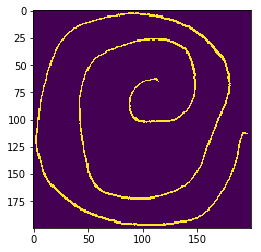

In [9]:
# The thresholding step segments the drawing from the input image, 
# making the drawing appear as white foreground on a black background
image = cv2.threshold(img, 0, 255,
               cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(image)

In [10]:
# quantify the image by 12996-features
features = quantify_image(image)
len(features)

12996

/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


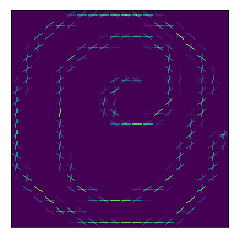

In [11]:
(H, hogImage) = feature.hog(image, orientations=9, pixels_per_cell=(10, 10),
                   cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",
                   visualise=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
 
plt.imshow(hogImage)
plt.xticks([]), plt.yticks([]);

In [12]:
def load_split(path):
     # grab the list of images in the input directory, then initialize
     # the list of data (i.e., images) and class labels
     imagePaths = list(paths.list_images(path))
     data = []
     labels = []

     # loop over the image paths
     for imagePath in tqdm(imagePaths):
          # extract the class label from the filename
          label = imagePath.split(os.path.sep)[-2]

          # load the input image, convert it to grayscale, and resize
          # it to 200x200 pixels, ignoring aspect ratio
          image = cv2.imread(imagePath)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
          image = cv2.resize(image, (200, 200))

          # threshold the image such that the drawing appears as white
          # on a black background
          image = cv2.threshold(image, 0, 255,
               cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

          # quantify the image
          features = quantify_image(image)

          # update the data and labels lists, respectively
          data.append(features)
          labels.append(label)

     # return the data and labels
     return (np.array(data), np.array(labels))

In [13]:
# define the path to the training and testing directories
trainingPath ="dataset/wave/training"
testingPath = "dataset/wave/testing"

In [14]:
print("[INFO] loading data...")
(trainX, trainY) = load_split(trainingPath)
(testX, testY) = load_split(testingPath)

  8%|▊         | 6/72 [00:00<00:01, 59.00it/s]

[INFO] loading data...


100%|██████████| 30/30 [00:00<00:00, 57.82it/s]


In [15]:
# encode the labels as integers
le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

# initialize our trials dictionary
trials = {}

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

HGBC=HistGradientBoostingClassifier(learning_rate=0.01,min_samples_leaf=5,max_depth=3)
HGBC.fit(trainX,trainY)
print(HGBC)

HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.01,
                               loss='auto', max_bins=256, max_depth=3,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=5, n_iter_no_change=None,
                               random_state=None, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0)


In [22]:
print(skm.classification_report(testY,HGBC.predict(testX)))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.72      0.87      0.79        15

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30



In [17]:
# loop over the number of trials to run
ntrials=5
for i in tqdm_notebook(range(0, ntrials)):
     # train the model
     print("[INFO] training model {} of {}...".format(i + 1,ntrials))
     model = RandomForestClassifier(n_estimators=100)
     model.fit(trainX, trainY)

     # make predictions on the testing data and initialize a dictionary
     # to store our computed metrics
     predictions = model.predict(testX)
     metrics = {}

     # compute the confusion matrix and and use it to derive the raw
     # accuracy, sensitivity, and specificity
     cm = confusion_matrix(testY, predictions).flatten()
     (tn, fp, fn, tp) = cm
     metrics["acc"] = (tp + tn) / float(cm.sum())
     metrics["sensitivity"] = tp / float(tp + fn)
     metrics["specificity"] = tn / float(tn + fp)

     # loop over the metrics
     for (k, v) in metrics.items():
          # update the trials dictionary with the list of values for
          # the current metric
          l = trials.get(k, [])
          l.append(v)
          trials[k] = l

[INFO] training model 1 of 5...
[INFO] training model 2 of 5...
[INFO] training model 3 of 5...
[INFO] training model 4 of 5...
[INFO] training model 5 of 5...



In [18]:
cmo=confusion_matrix(testY, predictions)

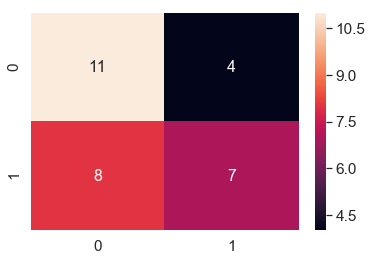

In [19]:
import seaborn as sns
import pandas as pd
df_cm = pd.DataFrame(cmo, range(2),
                  range(2))
#plt.figure(figsize = (10,7))

sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size


In [20]:
# loop over our metrics
for metric in ("acc", "sensitivity", "specificity"):
     # grab the list of values for the current metric, then compute
     # the mean and standard deviation
     values = trials[metric]
     mean = np.mean(values)
     std = np.std(values)

     # show the computed metrics for the statistic
     print(metric)
     print("=" * len(metric))
     print("𝝁={:.4f}, 𝝈={:.4f}".format(mean, std))
     print("")

acc
===
𝝁=0.6800, 𝝈=0.0542

sensitivity
𝝁=0.6667, 𝝈=0.1116

specificity
𝝁=0.6933, 𝝈=0.0533



In [21]:
# randomly select a few images and then initialize the output images
# for the montage
testingPaths = list(paths.list_images(testingPath))
idxs = np.arange(0, len(testingPaths))
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

In [22]:
# loop over the testing samples
for i in idxs:
     # load the testing image, clone it, and resize it
     image = cv2.imread(testingPaths[i])
     output = image.copy()
     output = cv2.resize(output, (128, 128))

     # pre-process the image in the same manner we did earlier
     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
     image = cv2.resize(image, (200, 200))
     image = cv2.threshold(image, 0, 255,
          cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

     # quantify the image and make predictions based on the extracted
     # features using the last trained Random Forest
     features = quantify_image(image)
     preds = model.predict([features])
     label = le.inverse_transform(preds)[0]

     # draw the colored class label on the output image and add it to
     # the set of output images
     color = (255, 0, 0) if label == 'parkinson' else (0, 0, 255)
       
     cv2.putText(output, label, (3, 20),cv2.FONT_HERSHEY_SIMPLEX , 0.5,color, 2)
     images.append(output)

In [23]:
# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

# show the output montage
cv2.imshow("Output", montage)
#cv2.waitKey(0)

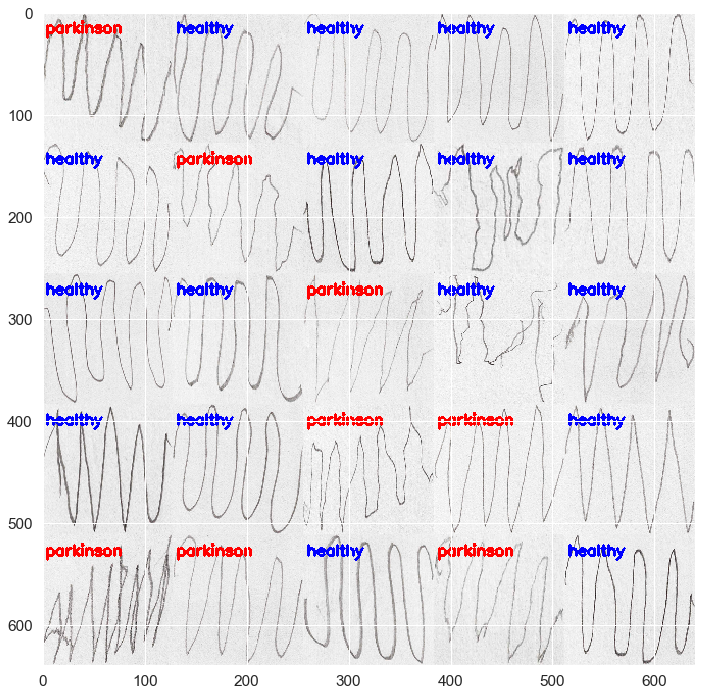

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.imshow(montage)
plt.show()